In [1]:
%load_ext autoreload
%autoreload 2

# Interweaving RL, IRL steps, like an IRL Algorithm.

What does it buy us? 

In [2]:
# First, set everything up.
#start by adding parent directory...
import os
import sys
import inspect

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir) 

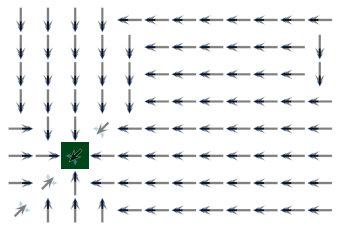

In [3]:
# Now build environment
import numpy as np
import primitives as prim
from environs import GridWorld
from utils import broadcompress

GW = GridWorld.make(12,8, noise=0.1)
R1pt = np.zeros(GW.Sshape)
R1pt[21] = 2

pi0 = prim.fwd(GW, R1pt, 0.9, policy_improve_iters=20, val_iters=30, temp=0)
GW.draw(states=R1pt, policy=pi0)

here's the same thing with a higher temperature

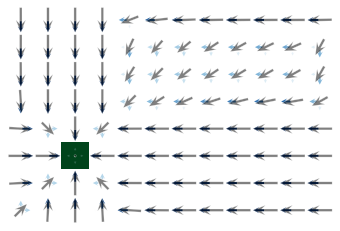

In [4]:
pi01 = prim.fwd(GW, R1pt, 0.9, policy_improve_iters=20, val_iters=30, temp=0.01)
GW.draw(states=R1pt, policy=pi01)

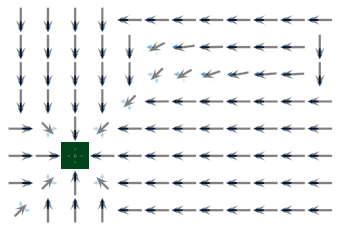

In [5]:
# An intermediate, slightly lower temperature
pi001 = prim.fwd(GW, R1pt, 0.9, policy_improve_iters=20, val_iters=30, temp=0.001)
GW.draw(states=R1pt, policy=pi001)

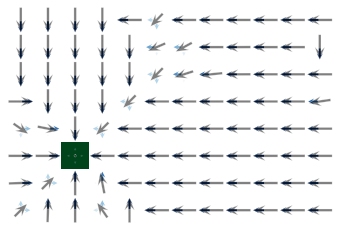

In [6]:
# Changing $\gamma$. For very close to 1, becomes sensitive to parity.
pi9999 = prim.fwd(GW, R1pt, 0.9999, policy_improve_iters=31, val_iters=50, temp=0.001)
GW.draw(states=R1pt, policy=pi9999)

states: log visitation probability, 1000 iters
policy: optimal for point reward.


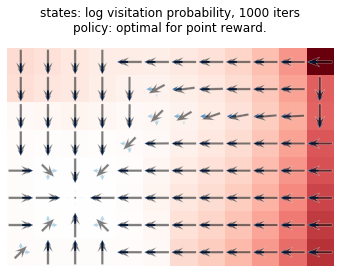

In [7]:
# V = prim.value_iter(GW, R1pt, 0.9, temperature=0.001)
#pi = prim.fwd(GW, R1pt, 0.9, policy_improve_iters=30, val_iters=50, temp=0.01)
D = prim.visitation_iter(GW, pi9999, iters=1000)

GW.draw(states=np.log(D), policy = pi001,descr=
"""states: log visitation probability, 1000 iters
policy: optimal for point reward."""
)

In [8]:
from dist import RawJointDist as RJD

policy: optimal for novelty reward.

states: log novelty reward


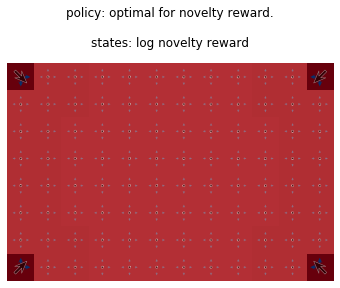

In [9]:
R = GW.novelty
V = prim.value_iter(GW, R, 0.9, temperature=0.01)
pi = prim.fwd(GW, R, 0.9, policy_improve_iters=30, val_iters=50, temp=0.01)
D = prim.visitation_iter(GW, pi, iters=1000)

GW.draw(states=np.log(D), policy = pi,descr=
"""policy: optimal for novelty reward.

states: log novelty reward"""
)

If the reward and policy already match for the same temperature, then it should do nothing.

max policy dist  (0 -> 1):  0.24724138762496212
max policy dist  (0 -> 1')  0.0
max policy dist  (1 -> 2)  0.06436635827692083
max policy dist  (0 -> 2')  0.0
Explained_variance: [0.96105332 0.03894668] 	(total: 1.000000)


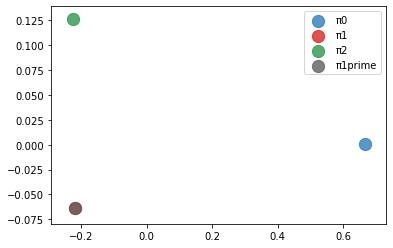

In [10]:
#DEBUGGING. 
# Currently, adjust_both should just be doing the same thing as 
# fwd, yet they give different results.
from viz import pca_view

πopt = prim.fwd(GW, R1pt, 0.9, policy_improve_iters=100, val_iters=100, temp=0.01)

π0 = prim.fwd(GW, R1pt, 0.9, policy_improve_iters=0, val_iters=30, temp=0.01)
π1 = prim.fwd(GW, R1pt, 0.9, policy_improve_iters=1, val_iters=30, temp=0.01)
π2 = prim.fwd(GW, R1pt, 0.9, policy_improve_iters=2, val_iters=30, temp=0.01)

#π2 = prim.fwd(GW, R1pt, 0.9, policy_improve_iters=12, val_iters=30, temp=0.01)

π1prime, _ = prim.adjust_both(GW, π0, R1pt, 0.9, value_iters=30, iters=1, temp=0.01)
π2prime, _ = prim.adjust_both(GW, π0, R1pt, 0.9, value_iters=30, iters=2, temp=0.01)


print("max policy dist  (0 -> 1): ", np.max(np.abs(π0-π1)) )
print("max policy dist  (0 -> 1') ", np.max(np.abs(π1-π1prime)) )
print("max policy dist  (1 -> 2) ", np.max(np.abs(π1-π2)) )
print("max policy dist  (0 -> 2') ", np.max(np.abs(π1-π1prime)) )

pca_view(π0=[π0], π1 = [π1], π2 = [π2], π1prime=[π1prime])



policy distance:  6.661338147750939e-14
reward distance:  0.0


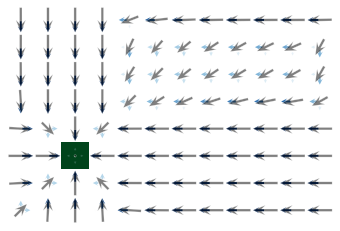

In [11]:
π_old = prim.fwd(GW, R1pt, 0.9, policy_improve_iters=30, 
                 val_iters=60, temp=0.01)
# Test a version of adjusting.
π_new, ρ_new = prim.adjust_both(GW, π_old, R1pt, 0.9, temp=0.01, 
                                value_iters=60, iters=10)
maxρnew = broadcompress(ρ_new).max(axis=1)
# Dnew = prim.visitation_iter(GW, π_new, iters=200)
GW.draw(states=np.log(1+maxρnew), policy=π_new)

print("policy distance: ", np.max(np.abs(pi01-π_new)) )
print("reward distance: ", np.max(np.abs(R1pt-ρ_new)) )

#assert np.allclose(pi, π_new)
#assert np.allclose(R1pt, ρ_new, atol=2E-8)

This gets thrown off by extremal values (presumably due to numerical error?)

In [12]:
# Test a version of adjusting.

π_new, ρ_new = prim.adjust_both(GW, pi9999, R1pt, 0.9999, temp=0.001)

In [13]:
maxρnew = utils.broadcompress(ρ_new).max(axis=1)
Dnew = prim.visitation_iter(GW, π_new, iters=200)
GW.draw(states=np.log(Dnew), policy=π_new)



AttributeError: module 'primitives' has no attribute 'broadcompress'

Note that in the case where the policy and reward do not match (here, a random policy), the operation does something (not insignificant, but local) to both.

In [ ]:
π_new, ρ_new, trace = prim.adjust_both(GW, GW.random_policy(det=False), R1pt, 0.1, 
                                       temp=0.01, store_iters="DπρV", iters=30)

maxρnew = prim.broadcompress(ρ_new).max(axis=1)
GW.draw(states=maxρnew, policy=π_new)

Let's now visualize the trace, by plotting a PCA of policy over time

In [ ]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

def iterates_PCA_view(trace):
    pca = PCA(n_components=2)
    ddata = np.array(trace).reshape(len(trace),-1)
    pca.fit(ddata[0:])
    expl = pca.explained_variance_ratio_
    print("Explained_variance:", expl, "\t(total: %f)"%sum(expl))

    #pca.transform(ddata).shape
    fig, ax = plt.subplots()
    X,Y = pca.transform(ddata)[:,:].T
    U,V = np.diff(X), np.diff(Y) 
#     norm = np.sqrt(U**2 + V**2)
#     norm = np.where(norm==0, 1, norm)

    ax.scatter(X,Y, s=100, c = np.linspace(0,1,len(X)))
    ax.plot(X,Y,'-', alpha=0.1)
    ax.quiver(X[:-1]+U/2, Y[:-1]+V/2, U/2, V/2, np.linspace(0,1,len(X)), pivot="mid", angles="xy", 
              zorder=4,headwidth=5, alpha=0.3)

In [ ]:
iterates_PCA_view(trace['π'])

In [ ]:
iterates_PCA_view(trace['ρ'])
